In [4]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
import matplotlib.patches as mpatches


import glob


import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Data

### Load in GEOS Chem Runs made from File Creation Notebook, Load in HEMCO Emissions Files

In [5]:
ds = xr.open_zarr('./nonuc_normal_GC')

In [6]:
ds_emis = xr.open_zarr('./emissions_HEMCO')

### Define variables and lists

In [7]:
#define Lat and Lon of the nested grid US

levels_dict = {'PM25':np.arange(0., 40., .5), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 40., 1.),
               'dif':np.arange(-1., 1.01, .01), 'regional_dif':np.arange(-1.5, 1.51, .01), 'regional_dif_tight':np.arange(-.3, .31, .01),
              'percent_dif_full':np.arange(-100, 101, 1), 'percent_dif_tight':np.arange(-10,10.1,.1)}


species_dict = {'PM25':'PM2.5 - Local Conditions', 'SO2':'Sulfur Dioxide', 'NO2':'Nitrogen dioxide (NO2)', 'O3':'Ozone', 'NOx':'Nitrogen Oxides (NO2+NO)'}

model_names = ds['model_name'].values

cmap_dif = 'BrBG_r'
cmap_conc = 'pink_r'
cmap_discrete = cm.get_cmap('Paired', 3) 

cities_dict = {'Bismarck':[46.8083, -100.7837],
               'Charlotte':[35.2271, -80.8431],
               'Los Angeles': [34.0522, -118.2437],
               'Memphis':[35.1495, -90.0490],
               'Pittsburgh':[40.4406, -79.9959],
               'Portland': [45.5051, -122.6750],
              'San Francisco':[37.775,-122.4183],
              'Salt Lake City':[40.7608, -111.8910],
              'Sacramento':[38.5816, -121.4944]}

# Plots

## US, concentrations

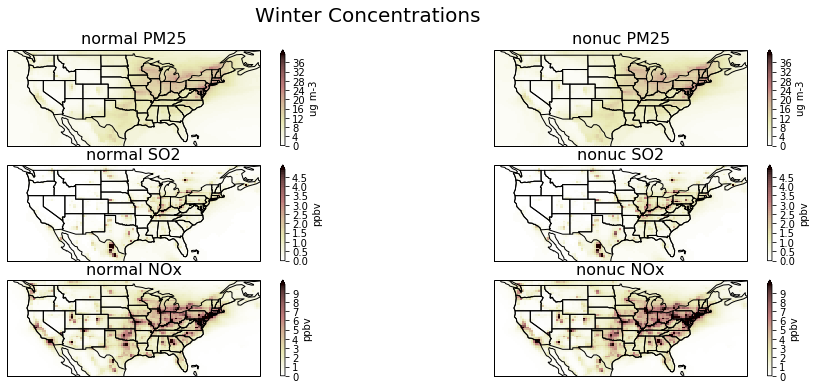

In [5]:
plotting.concentration_plot_seasonal(ds = ds, species_names = ['PM25','SO2','NOx'], season = 'DJF', model_names = model_names,  cmap = cmap_conc,
                        lat_lon = utils.lat_lon_dict['US_lat_lon'], shrink_cbar = 1,
                       figsize = [16,6])
plt.suptitle('Winter Concentrations', fontsize = 20);

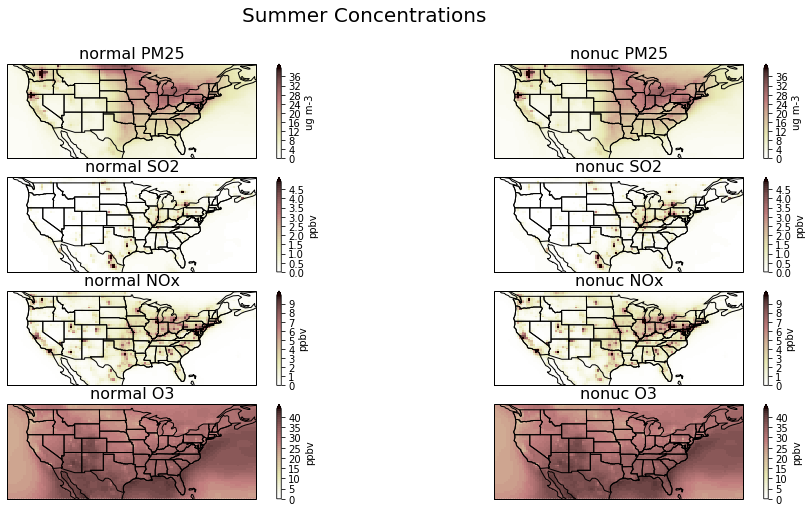

In [10]:
plotting.concentration_plot_seasonal(ds = ds, species_names = ['PM25','SO2','NOx','O3'], season = 'JJA', model_names = model_names,  cmap = cmap_conc,
                        lat_lon = utils.lat_lon_dict['US_lat_lon'], shrink_cbar = 1,
                       figsize = [16,8])
plt.suptitle('Summer Concentrations', fontsize = 20);

## US, differences

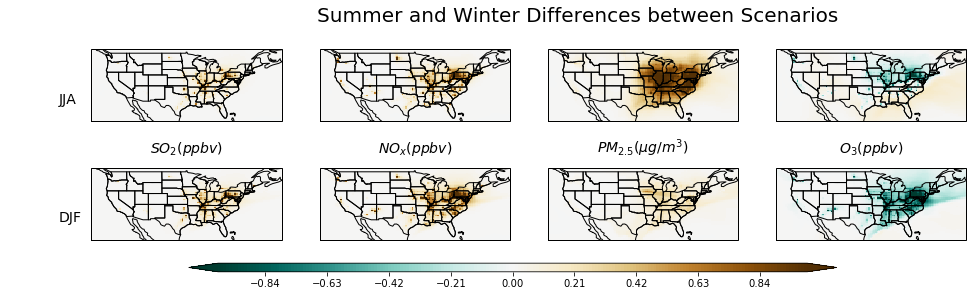

In [9]:
plotting.concentration_plot_seasonal_dif(ds = ds, seasons = ['JJA','DJF'], species_names = ['SO2','NOx','PM25','O3'], cmap = cmap_dif,
                   rows = 2, columns = 2, levels = levels_dict['dif'], lat_lon = utils.lat_lon_dict['US_lat_lon'],
                   figsize = [18,4], extension = 'both')

plt.suptitle(f'Summer and Winter Differences between Scenarios', fontsize = 20);
plt.savefig('./Figures/summer_winter_national_dif.png', bbox_inches = 'tight', dpi = 150)

## US, CH2O/NO2 Ratio and Ozone

Using the FNR ratio from Jin et al. 2017 (Evaluating a Space-Based Indicator of Surface Ozone-NOx-
VOC Sensitivity Over Midlatitude Source Regions
and Application to Decadal Trends)

<0.5 = VOC limited

0.5-0.8 = transitional

0.8> = NOx limited

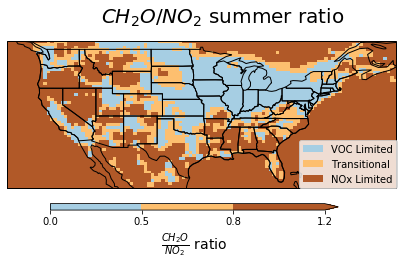

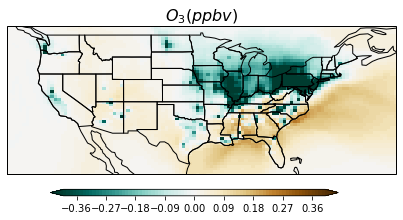

In [88]:
plotting.ratio_plot(ds = ds, season = 'JJA', species = 'CH2O_NO2', model_names = ['normal'], cmap = cmap_discrete,
                       rows = 1, columns = 1, levels = [0,.5,.8,1.2], lat_lon = utils.lat_lon_dict['US_lat_lon'], shrink_cbar = .7,
                       figsize = [8,3])
VOC_lim = mpatches.Patch(facecolor = cmap_discrete.colors[0], label = 'VOC Limited')
trans = mpatches.Patch(facecolor = cmap_discrete.colors[1], label = 'Transitional')
NOX_lim = mpatches.Patch(facecolor = cmap_discrete.colors[2], label = 'NOx Limited')
plt.legend(handles = [VOC_lim,trans,NOX_lim], loc='upper right', bbox_to_anchor=(1.22, 11.52));
plt.title('')
plt.suptitle(r'$CH_2O/NO_2$ summer ratio', fontsize = 20, y = 1);
plt.savefig('./Figures/summer_regime_national_ratio.png', bbox_inches = 'tight', dpi = 150)

plotting.concentration_plot_seasonal_dif(ds = ds, season = 'JJA', species = ['O3'], cmap = cmap_dif,
                       rows = 1, columns = 1, levels = np.arange(-.4,.41,.01), lat_lon = utils.lat_lon_dict['US_lat_lon'],
                       figsize = [8,3], 
                        extension = 'both')
plt.title('');

plt.savefig('./Figures/summer_regime_national_ozone.png', bbox_inches = 'tight', dpi = 150)

## US, emissions

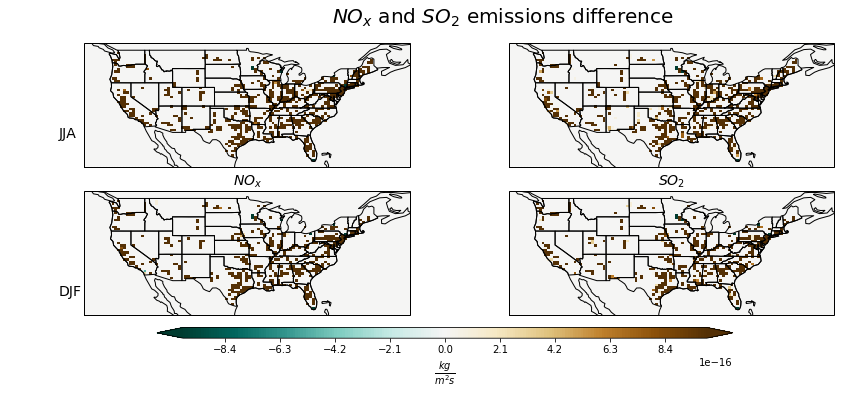

In [135]:
plotting.plot_emissions_dif(ds_emis.sel(model_name = 'nonuc'), 
                            ds_emis.sel(model_name = 'normal'), 
                            emissions = ['EmisNOx_Anthro', 'EmisSO2_Anthro'], seasons = ['JJA','DJF'], 
                            levels = np.arange(-1e-15,1.01e-15,1e-17), 
                            lat_lon = utils.lat_lon_dict['US_lat_lon'],
                           figsize = [16,5])
plt.suptitle(r'$NO_x$ and $SO_2$ emissions differences', fontsize = 20, );
plt.savefig('./Figures/summer_nox_emissions.png', bbox_inches = 'tight', dpi = 150);

# Calculate numerical differences between each scenario

In [202]:
### find the max difference between summer and winter PM changes
da = (ds['dif_PM25'].groupby('time.season').mean().sel(season = 'JJA') - ds['dif_PM25'].groupby('time.season').mean().sel(season = 'DJF'))
print(da.where(da == da.max(), drop = True).squeeze().values)
da.where(da == da.max(), drop = True).squeeze()

1.252369


<xarray.DataArray 'dif_PM25' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 40.5
    lev      float64 0.9925
    lon      float64 -77.5

In [185]:
for species in ['PM25','NOx','SO2','O3']:
    for season in ['DJF','JJA']:
        print(f'National percent change in {species} in {season} ' + 
              str(ds[f'percent_dif_{species}'].groupby('time.season').mean().sel(season = season).mean(dim = ['lat','lon']).values.item()))
        print(f'Max percent change in {species} overall ' + 
              str(ds[f'percent_dif_{species}'].values.max()))

        print(f'National change in {species} in {season} ' + 
              str(ds[f'dif_{species}'].groupby('time.season').mean().sel(season = season).mean(dim = ['lat','lon']).values.item()))
        print(f'Max change in {species} overall ' + 
              str(ds[f'dif_{species}'].values.max()))

National percent change in PM25 in DJF 0.2391858845949173
Max percent change in PM25 overall 40.46565
National change in PM25 in DJF 0.01752789318561554
Max change in PM25 overall 10.776249
National percent change in PM25 in JJA 0.44556450843811035
Max percent change in PM25 overall 40.46565
National change in PM25 in JJA 0.061656851321458817
Max change in PM25 overall 10.776249
National percent change in NOx in DJF 1.0070946216583252
Max percent change in NOx overall 1020.4929
National change in NOx in DJF 0.029100127518177032
Max change in NOx overall 40.136158
National percent change in NOx in JJA 0.7773076295852661
Max percent change in NOx overall 1020.4929
National change in NOx in JJA 0.02143723890185356
Max change in NOx overall 40.136158
National percent change in SO2 in DJF 2.339937448501587
Max percent change in SO2 overall 3764.919
National change in SO2 in DJF 0.013260403648018837
Max change in SO2 overall 18.972115
National percent change in SO2 in JJA 2.29502272605896
Ma

def global_argmin(da):
    xmin = da.min(dim=['lon'])
    xargmin = da.argmin(dim='lon').values
    ymin = xmin.min(dim=['lat'])
    yargmin = xmin.argmin(dim='lat').values
    targmin = ymin.argmin(dim = 'time').values 
    return [xargmin[targmin, yargmin], yargmin[targmin], targmin], ymin[targmin].values

In [205]:
for species in ['PM25','NOx','SO2','O3']:
    print(f'{species} max ' + str(ds[f'dif_{species}'].where(ds[f'dif_{species}']==ds[f'dif_{species}'].max(), drop=True).squeeze()) 
          + ' ' + str(ds[f'dif_{species}'].where(ds[f'dif_{species}']==ds[f'dif_{species}'].max(), drop=True).squeeze().values))

PM25 max <xarray.DataArray 'dif_PM25' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 39.5
    lev      float64 0.9925
    lon      float64 -92.5
    time     datetime64[ns] 2016-06-07T12:00:00
Attributes:
    units:    PM $\mu$g m$^{-3}$ 10.776249
NOx max <xarray.DataArray 'dif_NOx' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 40.5
    lev      float64 0.9925
    lon      float64 -79.38
    time     datetime64[ns] 2016-12-08T12:00:00
Attributes:
    units:    ppbv 40.136158
SO2 max <xarray.DataArray 'dif_SO2' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 40.5
    lev      float64 0.9925
    lon      float64 -80.62
    time     datetime64[ns] 2016-11-05T12:00:00
Attributes:
    units:    ppbv 18.972115
O3 max <xarray.DataArray 'dif_O3' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 33.5


In [206]:
for species in ['PM25','NOx','SO2','O3']:
     print(f'{species} min ' + str(ds[f'dif_{species}'].where(ds[f'dif_{species}']==ds[f'dif_{species}'].min(), drop=True).squeeze()) 
          + ' ' + str(ds[f'dif_{species}'].where(ds[f'dif_{species}']==ds[f'dif_{species}'].min(), drop=True).squeeze().values))

PM25 min <xarray.DataArray 'dif_PM25' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 41.0
    lev      float64 0.9925
    lon      float64 -80.62
    time     datetime64[ns] 2016-03-06T12:00:00
Attributes:
    units:    PM $\mu$g m$^{-3}$ -4.8197365
NOx min <xarray.DataArray 'dif_NOx' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 35.5
    lev      float64 0.9925
    lon      float64 -80.62
    time     datetime64[ns] 2016-03-23T12:00:00
Attributes:
    units:    ppbv -0.96628666
SO2 min <xarray.DataArray 'dif_SO2' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 38.5
    lev      float64 0.9925
    lon      float64 -85.0
    time     datetime64[ns] 2016-12-08T12:00:00
Attributes:
    units:    ppbv -0.5080693
O3 min <xarray.DataArray 'dif_O3' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=()>
Coordinates:
    lat      float64 4

In [57]:
print('max difference in PM '+ str(ds['dif_PM25'].max().values) + ' and min ' + str(ds['dif_PM25'].min().values))
print('max difference in O3 '+ str(ds['dif_O3'].max().values) + ' and min ' + str(ds['dif_O3'].min().values))


max difference in PM 10.776249 and min -4.8197365
max difference in O3 1.7619972 and min -21.864635
